## Importing the libraries

In [37]:
import numpy as np
import pandas as pd
import librosa
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

## 顯示音頻訊號圖

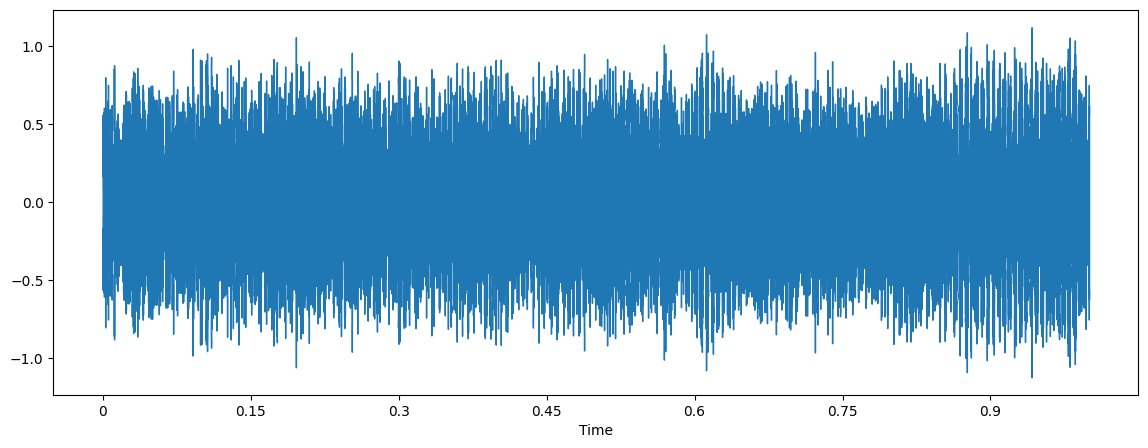

In [38]:
path = '/kaggle/input/recoding-data/UAV Recordings 1s/UAV Recordings 1s/Healthy/recording_2023-03-02_14-07-33_012.wav'

# 讀取音頻文件

plt.figure(figsize=(14,5))
data, sampling_rate = librosa.load(path)
librosa.display.waveshow(data,sr=sampling_rate)

## 顯示STFT特徵圖

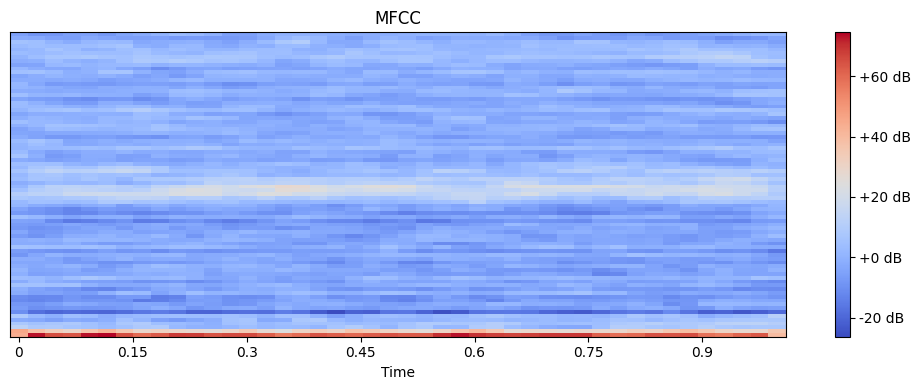

In [39]:
# 提取STFT特徵
mfccs_features = librosa.feature.mfcc(y = data, sr = sampling_rate, n_mfcc = 80)

# 繪製STFT
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs_features, x_axis='time', sr=sampling_rate)
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC')
plt.tight_layout()
plt.show()

## 加載音頻訊號

In [40]:
data_path = '/kaggle/input/recoding-data/UAV Recordings 1s/UAV Recordings 1s'

## 音頻訊號進行STFT特徵提取

In [41]:
def load_data(data_dir):
    datasets = []
    labels = []
    categories = os.listdir(data_dir)
    for index, folder in enumerate(categories):
        for filename in os.listdir(data_dir+"/"+folder):
            data, sampling_rate = librosa.load(data_dir+"/"+folder+"/"+filename)
            stft_feature = np.abs(librosa.stft(data))
            scaled_features = np.mean(stft_feature.T,axis=0)
            datasets.append(np.array(scaled_features))
            labels.append(categories[index])
    return np.array(datasets), np.array(labels)

datasets, labels = load_data(data_path)

In [42]:
datasets = datasets.astype('float32')

labelencoder = LabelEncoder()

labelsOneHot = to_categorical(labelencoder.fit_transform(labels))

## 切分成訓練資料、測試資料，8:2的比例

In [43]:
X_train, X_test, y_train, y_test = train_test_split(datasets, labelsOneHot, test_size = 0.2, stratify = labelsOneHot, random_state = 3)

print("----------Train-------------")
print(X_train.shape)

print("----------Test--------------")
print(X_test.shape)

----------Train-------------
(4512, 1025)
----------Test--------------
(1128, 1025)


## 類別數量

In [44]:
num_classes = len(np.unique(labels))

## 建立NN模型

In [45]:
model=Sequential()

#Input layer
model.add(Flatten(input_shape=(datasets.shape[1],)))

#hidden layer 1
model.add(Dense(512, Activation('relu')))

#hidden layer 2
model.add(Dense(128, Activation('relu')))

#hidden layer 3
model.add(Dense(64, Activation('relu')))

# 使用Dropout防止過度擬合
model.add(Dropout(0.25))

#Output layer
model.add(Dense(num_classes, Activation('softmax')))

In [46]:
# 選擇損失函數、優化方法及成效衡量方式
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 1025)              0         
                                                                 
 dense (Dense)               (None, 512)               525312    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 5)                 325       
                                                                 
Total params: 599557 (2.29 MB)
Trainable params: 59955

## 模型訓練

In [47]:
train_history = model.fit(X_train, y_train, validation_split=0.2, batch_size = 100, epochs = 150, verbose=2)

Epoch 1/150
37/37 - 2s - loss: 2.6093 - accuracy: 0.3297 - val_loss: 1.5007 - val_accuracy: 0.3887 - 2s/epoch - 47ms/step
Epoch 2/150
37/37 - 0s - loss: 1.3441 - accuracy: 0.4572 - val_loss: 1.3218 - val_accuracy: 0.4773 - 356ms/epoch - 10ms/step
Epoch 3/150
37/37 - 0s - loss: 1.2595 - accuracy: 0.5048 - val_loss: 1.0947 - val_accuracy: 0.5393 - 373ms/epoch - 10ms/step
Epoch 4/150
37/37 - 0s - loss: 0.9935 - accuracy: 0.6115 - val_loss: 0.9630 - val_accuracy: 0.6146 - 351ms/epoch - 9ms/step
Epoch 5/150
37/37 - 0s - loss: 0.9816 - accuracy: 0.6176 - val_loss: 0.9150 - val_accuracy: 0.6645 - 385ms/epoch - 10ms/step
Epoch 6/150
37/37 - 0s - loss: 0.8305 - accuracy: 0.6766 - val_loss: 0.8860 - val_accuracy: 0.6423 - 343ms/epoch - 9ms/step
Epoch 7/150
37/37 - 0s - loss: 0.8739 - accuracy: 0.6534 - val_loss: 0.8899 - val_accuracy: 0.6755 - 380ms/epoch - 10ms/step
Epoch 8/150
37/37 - 0s - loss: 0.8411 - accuracy: 0.6622 - val_loss: 0.9838 - val_accuracy: 0.6058 - 377ms/epoch - 10ms/step
Epoch

## 評估訓練結果

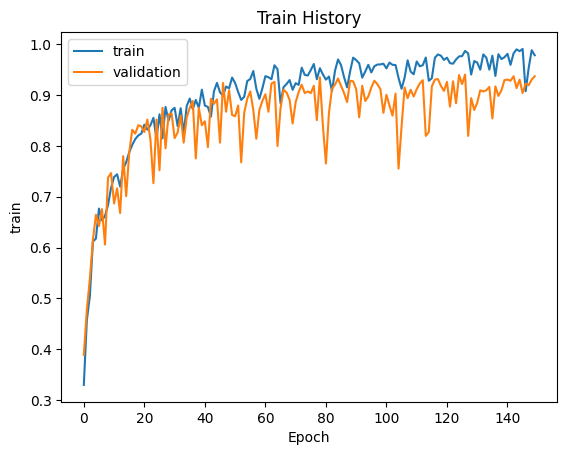

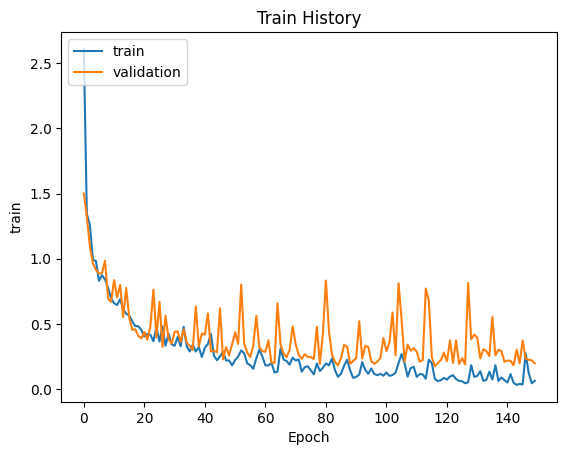

In [48]:
def show_train_history(train_history, train, validation):

    plt.plot(train_history.history[train])

    plt.plot(train_history.history[validation])

    plt.title('Train History')

    plt.ylabel('train')

    plt.xlabel('Epoch')

    plt.legend(['train', 'validation'], loc='upper left')

    plt.show()
    

show_train_history(train_history, 'accuracy', 'val_accuracy')
show_train_history(train_history, 'loss', 'val_loss')

## 使用未參與訓練的測試資料測試，模型準確率

In [49]:
scores = model.evaluate(X_test,y_test,verbose=0)

print('Accuracy = ', scores[1])

Accuracy =  0.936170220375061


## 評估訓練結果

36/36 [==============================] - 0s 3ms/step


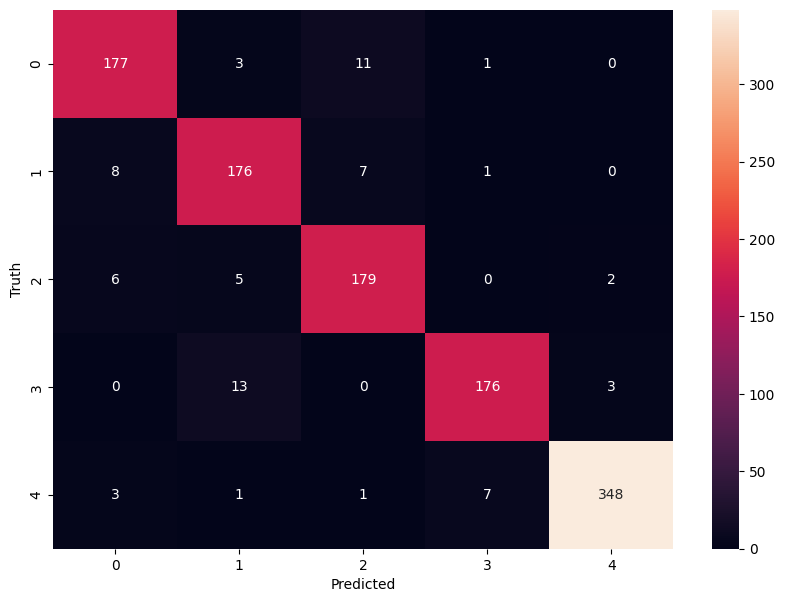

In [50]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)
confusion_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()